# Import Library

Di sini akan dilakukan import dari library-library yang dibutuhkan untuk pembuatan CNN. Library utama adalah TensorFlow untuk Deep Learning.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.4


In [ ]:
from tensorflow.keras.layers import Input, Lambda,\
Dense, Flatten, Conv2D, BatchNormalization, \
ZeroPadding2D, MaxPooling2D, Activation, add

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image \
import ImageDataGenerator

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

# Konfigurasi Data

Pada bagian ini akan dilakukan konfigurasi data untuk menyamakan semua parameter, seperti ukuran gambar, letak data, dan sebagainya.

In [ ]:
# Mengubah ukuran data agar seragam
IMAGE_SIZE = [224, 224]

# Konfigurasi training
epochs = 15
batch_size = 128

In [ ]:
# Letak dataset
train_path = '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
valid_path = '../input/blood-cells/dataset2-master/dataset2-master/images/TEST'

In [ ]:
# Digunakan untuk mendapatkan jumlah file/data
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [ ]:
# Digunakan untuk mendapatkan jumlah class/label
folders = glob(train_path + '/*')

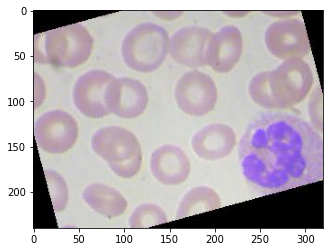

../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_112_8845.jpeg


In [ ]:
# Mengecek data citra
cek_random = np.random.choice(image_files)
plt.imshow(image.load_img(cek_random))
plt.show()

print(cek_random)

# Pembuatan Arsitektur

Di sini akan menggunakan arsitektur ResNet yang sedikit dimodifikasi untuk menyesuaikan dengan dataset.

In [ ]:
# Pembuatan blok Identity
def identity_block(input_, kernel_size, filters):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1),
               kernel_initializer='he_normal'
               )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
               )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               kernel_initializer='he_normal'
               )(x)
    x = BatchNormalization()(x)

    x = add([x, input_])
    x = Activation('relu')(x)
    return x

In [ ]:
# Pembuatan blok Convolution
def conv_block(input_,
               kernel_size,
               filters,
               strides=(2, 2)):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), strides=strides,
               kernel_initializer='he_normal'
               )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
               )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               kernel_initializer='he_normal'
               )(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(f3, (1, 1), strides=strides,
                      kernel_initializer='he_normal'
                      )(input_)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [ ]:
# Arsitektur layer ResNet kustom yang disesuaikan dengan dataset
i = Input(shape=IMAGE_SIZE + [3])

x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(64, (7, 7),
           strides=(2, 2),
           padding='valid',
           kernel_initializer='he_normal'
           )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

2022-06-25 00:06:58.935588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 00:06:59.032821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 00:06:59.033604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 00:06:59.034999: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
# Fully Connected Layer
x = Flatten()(x)

prediction = Dense(
    len(folders),
    activation='softmax'
    )(x)

In [ ]:
print(len(folders))
# Karena tiap class memiliki foldernya tersendiri

4


In [ ]:
# Membuat objek Model
model = Model(inputs=i, outputs=prediction)

In [ ]:
# Melihat struktur keseluruhan model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

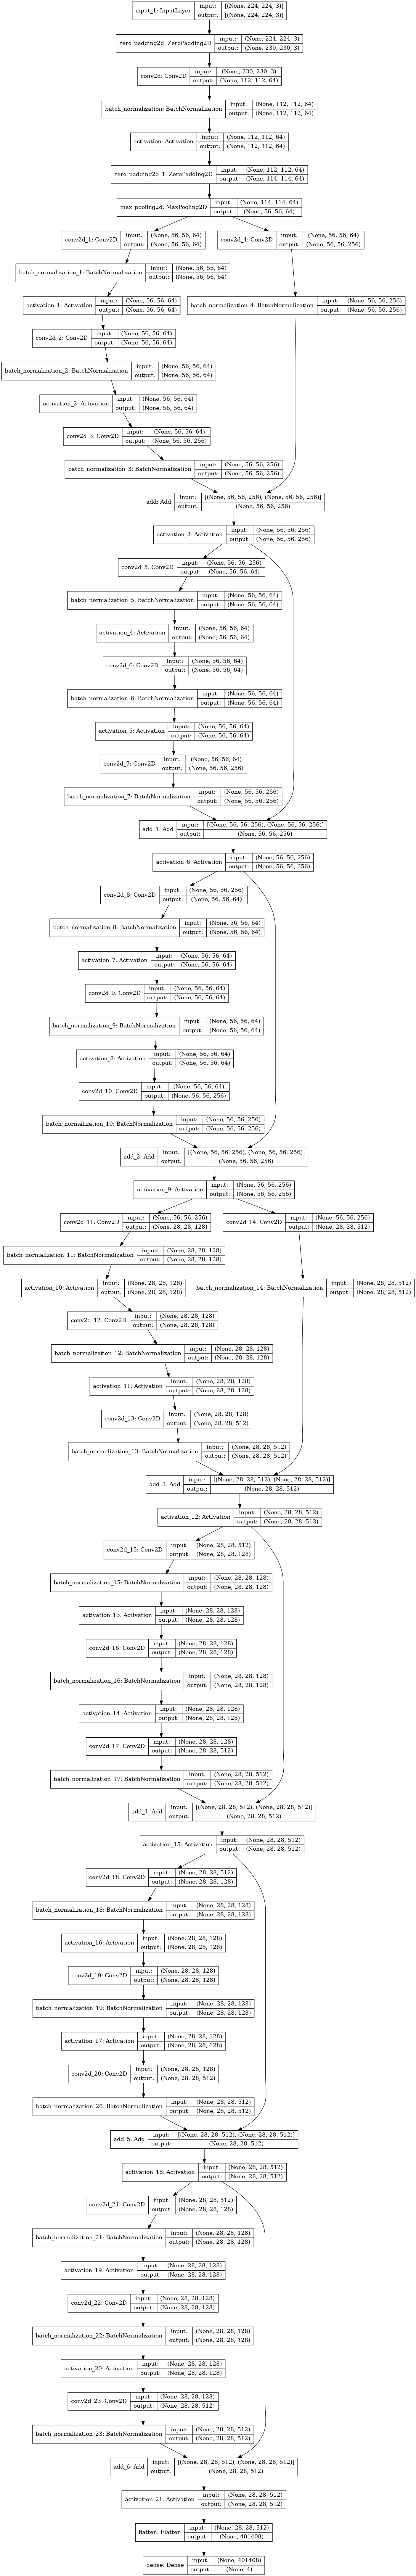

In [ ]:
# Memvisualisasikan arsitektur
from keras.utils.vis_utils import plot_model

plot_model(
    model,
    to_file='model_plot.png',
    show_shapes=True,
    show_layer_names=True
    )

# Image Augmentation

Pada image augmentation ini, akan digunakan fungsi ImageDataGenerator. Hal ini berfungsi agar pada setiap iterasi epoch yang berlangsung, data yang digunakan akan dilakukan image augmentation. Jadi jumlah data dapat tetap sama, akan tetapi dalam saat proses training, jumlah data akan ditransformasi berbeda-beda tiap putaran epoch.

In [ ]:
# Pembuatan instance untuk ImageDataGenerator
def preprocess_input2(x):
  x /= 127.5
  x -= 1.
  return x

train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input2
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input2
)

In [ ]:
# Image augmentation untuk data testing
# Data test menggunakan data yang sama dengan
# data validation
test_gen = val_gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    class_mode='sparse'
    )

# Mengecek label dan nama kelasnya untuk plot
# confusion matrix
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min: -1.0 max: 1.0


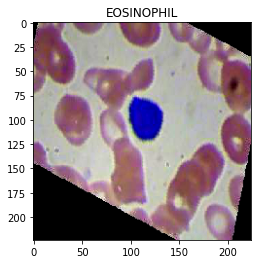

In [ ]:
# Melihat salah satu data
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [ ]:
# Mendefinisikan data training dan data validation
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)

# Cetak hanya sebagai informasi saja
print(
    "Data Training: ",
    "{:.2f}".format(9957/(9957+2487)*100), "%")
print(
    "Data Validasi/Testing: ",
    "{:.2f}".format(2487/(9957+2487)*100), "%")

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Data Training:  80.01 %
Data Validasi/Testing:  19.99 %


# Model Fitting

Pada bagian ini akan dilakukan compiling model untuk menyimpan arsitektur tersebut. Kemudian akan diberikan optimizer agar hasil akurasi bisa menjadi lebih baik. Model fitting ini akan menjalankan CNN yang telah dikonfigurasi sebelumnya, dan akan memakan beberapa waktu untuk melakukan training dari data tersebut.

In [ ]:
# Di sini digunakan optimizer Adam
model.compile(
  # Categorical untuk multiclass
  loss='sparse_categorical_crossentropy',
  optimizer=Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [ ]:
# Model fitting
checkpoint_filepath = '/tmp/checkpoint'
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(
      monitor='loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True),
  ]
)

2022-06-25 00:07:12.813016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-06-25 00:07:18.398369: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


77/77 [==============================] - 178s 2s/step - loss: 37.1832 - accuracy: 0.3043 - val_loss: 3.4858 - val_accuracy: 0.2488
Epoch 2/15
77/77 [==============================] - 138s 2s/step - loss: 2.1845 - accuracy: 0.5733 - val_loss: 2.2112 - val_accuracy: 0.4753
Epoch 3/15
77/77 [==============================] - 138s 2s/step - loss: 1.2126 - accuracy: 0.7845 - val_loss: 2.9770 - val_accuracy: 0.5329
Epoch 4/15
77/77 [==============================] - 138s 2s/step - loss: 1.0550 - accuracy: 0.8082 - val_loss: 6.0435 - val_accuracy: 0.4749
Epoch 5/15
77/77 [==============================] - 138s 2s/step - loss: 0.6072 - accuracy: 0.8829 - val_loss: 1.1698 - val_accuracy: 0.7656
Epoch 6/15
77/77 [==============================] - 138s 2s/step - loss: 0.3386 - accuracy: 0.9104 - val_loss: 1.6518 - val_accuracy: 0.7763
Epoch 7/15
77/77 [==============================] - 138s 2s/step - loss: 0.2129 - accuracy: 0.9373 - val_loss: 1.1816 - val_accuracy: 0.7817
Epoch 8/15
77/77 [=====

# Plot Metrik Akurasi

Dalam bagian ini, akan dibuatkan plot grafik yang dapat digunakan untuk memvisualisasikan hasil dari prediksi model yang telah diproses.

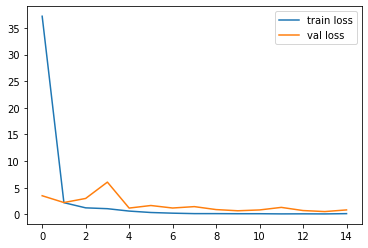

In [ ]:
# Melihat graf loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

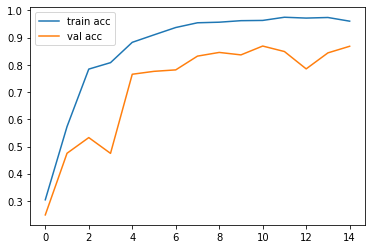

In [ ]:
# Melihat graf akurasi
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

Di bawah ini adalah pendefinisian function untuk pembuatan confusion matrix.

In [ ]:
def get_confusion_matrix(data_path, N):
  # Diperlukan untuk melihat apakah data dalam urutan yang tepat
  # untuk kedua prediksi dan target
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
[[2359    0    0  138]
 [   0 2482    0    1]
 [   3   33 2410   32]
 [  15    0    0 2484]]


In [ ]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
[[485   0   0 138]
 [  0 620   0   0]
 [ 25   0 465 130]
 [ 33   0   1 590]]


Di bawah ini merupakan pendefinisian function untuk pembuatan confusion matrix dengan MatPlotLib.

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion Matrix untuk Data Training

Confusion matrix, without normalization
[[2359    0    0  138]
 [   0 2482    0    1]
 [   3   33 2410   32]
 [  15    0    0 2484]]


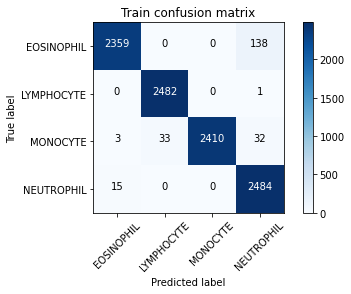

In [ ]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

In [ ]:
# Akurasi Test Set
np.trace(cm) / cm.sum()

0.9777041277493221

Confusion Matrix untuk Data Testing/Validation

Confusion matrix, without normalization
[[485   0   0 138]
 [  0 620   0   0]
 [ 25   0 465 130]
 [ 33   0   1 590]]


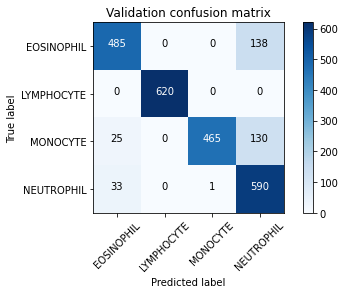

In [ ]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [ ]:
# Akurasi Validation Set
np.trace(valid_cm) / valid_cm.sum()

0.8685162846803377

Based on Yvtsan Levy (2021) "96% Accuracies Blood cell recognistion with ResNet" (https://www.kaggle.com/code/yvtsanlevy/96-accuracies-blood-cell-recognistion-with-resnet) with a very few modifications.

All credit goes to the original creator, as this is only for educational purposes.